# Reptile: A Scalable Meta-Learning Algorithm [Paper](https://arxiv.org/abs/1803.02999)
* Application of the Shortest Descent algorithm to the meta-learning setting, 
* Mathematically similar to first-order MAML (which is a version of the well-known MAML algorithm)


### Assume we have the following input
* Among the training data images listed below, which one is the most simiilar image to the input?
![reptile_image](https://openai.com/content/images/2018/03/Screenshot-2018-03-07-12.04.49.png)




* Meta learning is all about model agnostic and fast adaptation
    * Model agnostic: MAML could be applied anywhere regardless of the model using gradient descent 
    * Fast adaptation: adapting to any new tasks fast

## Meta-Learning formulation

$$\phi=argmax_{\phi} \log p(\phi|D)$$ , where $\phi$ is model parameters and $D$ is the training dataset. 

Now we take additional data from other tasks, $D_{meta}$

$$\phi=argmax_{\phi} \log p(\phi|D, D_{meta}) $$, $D_{meta} = \{D_1, ...D_n\}, D_i =  \{(x_1^i, y_1^i), ...(x_k^i, y_k^i)\}$


For meta learning setup, our $k$ is small, but $n$ is large.

## How Reptile Works
* Reptile seeks an initialization for the parameters of a neural network, such that the network can be fine-tuned using a small amount of data from a new task. 
* MAML unrolls and differentiates through the computation graph of the gradient descent algorithm, which requires calculating the second order derivative of the loss function w.r.t meta parameters 
* While Reptile simply performs stochastic gradient descent (SGD) (first order derivative) on each task in a standard way 

**Why reptile is first order**

* it does not unroll a computation graph or calculate any second derivatives. 


## Algorithm
![Reptile_Algorithm](https://lilianweng.github.io/lil-log/assets/images/reptile-algo.png)

## Import following packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import urllib3
import os
urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.

# Omniglot Dataset [link](https://www.tensorflow.org/datasets/catalog/omniglot)
* The Omniglot dataset is a dataset of 1,623 characters taken from 50 different alphabets, with 20 examples for each character.
    * Large number of classes to train the initial model 
* For the few-shot learning task, `k` samples (or "shots") are drawn randomly from `n` randomly-chosen classes. 
* These `n` classes are used to create a new set of temporary labels to use to test the model's ability to learn a new task given few examples. 
* In other words, if you are training on 5 classes, your new class labels will be one of 0, 1, 2, 3, or 4.
* Omniglot is a great dataset for this task since there are many different classes to draw from, with a reasonable number of samples for each class.


In [4]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        # num_classes * shots = minibatch size
        temp_labels = np.zeros(shape=(num_classes * shots)) 
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        
        # for meta testing, split = True 
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        
        # class_idx : Pseudo label, 
        # class_obj : Omniglot label 
        for class_idx, class_obj in enumerate(label_subset):
            # As our minibatch size is num_classes * shots, 
            # the range [class_idx * shots: (class_idx + 1) * shots] can be assigned a temporary class_idx 
            # which is used for few shot learning
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset. (Test after meta testing)
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[class_obj], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[class_obj], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset

# Visualizing Omniglot


In [5]:
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)

# Meta Learning의 2 Step


## 1) Meta training (과제)
- Meta testing 이전의 Meta training
- 과제에서는 meta training model을 만들어 조교가 학습한 결과와 비슷하면 됨

## 2) Meta testing (실습)
- 조교들이 Meta training을 이미 완료한 상태이다
- Meta training을 통하여 checkpoint를 만들어둠
- Checkpoint로부터 meta testing 진행


# Meta Testing 실습 진행

## a) Hyperparameters

In [6]:
learning_rate = 0.003

# For meta testing step
eval_batch_size = 25 
eval_iters = 10

# K shot n way
shots = 5
classes = 5

## b) Build Model
* 4 conv blocks 
* Each block comprises 64 filter (3 x 3, strides=2,padding="same"), BN, ReLU
* Results in a 64-dimensional output space
* Trained Prototypical Networks in 5-shot scenario
* Models were trained via SGD
* Initial learning rate: 3e-3 

In [7]:
# TODO complete conv_bn as the description
def conv_bn(x):
    x = ...
    x = ...
    return layers.ReLU()(x)

def create_model(input_shape=(28,28,1)):
    inputs = layers.Input(shape=input_shape)
    x = conv_bn(inputs)
    x = conv_bn(x)
    x = conv_bn(x)
    x = conv_bn(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()
model.compile()
# TODO setup the optimizer with SGD and initial learning rate
optimizer = ...

## c) Load checkpoint for meta trained model

In [8]:
checkpoint_path = "meta/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Save the weights using the `checkpoint_path` format
model.load_weights(checkpoint_path.format(epoch=0))

## d) 실습 Meta Testing

In [9]:
from tqdm import tqdm
losses = []
accuracy = 0

# TODO Sample a mini dataset from the full dataset using the hyperparameters defined above
train_set, test_images, test_labels = test_dataset.get_mini_dataset(...)


old_vars = model.get_weights()
# TODO Train on the samples and get the resulting accuracies.
for images, labels in tqdm(train_set, desc="iters"):
    with tf.GradientTape() as tape:
        preds = ...
        loss = ...
        losses.append(tf.math.reduce_sum(loss))
        
    grads = ...
    optimizer.apply_gradients(...)

# Get prediction after meta testing (few shot) 
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()
num_correct = (test_preds == test_labels).sum()

# Reset the weights after getting the evaluation accuracy
model.set_weights(old_vars)
accuracy = num_correct / classes # n = 5 way accuracy


print(
    "test accuracy = %f" % (accuracy)
)

iters: 100%|██████████| 10/10 [00:00<00:00, 65.18it/s]


test accuracy = 1.000000


## e) Visualizing Results
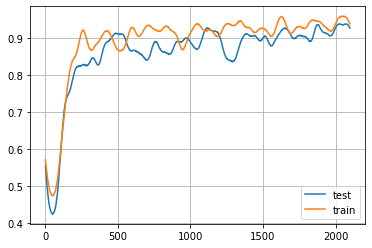

In [10]:
_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

## Pros of Meta Learning: Fast adaptation
- Looking at the graph below, we see that after 1 iteration of training / testing, meta learning performs very well for the rest

In [13]:
plt.figure(1)
x = [i+1 for i in range(len(losses))]
plt.plot(x, losses)
plt.xticks(x)
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("Test loss")

Text(0.5, 1.0, 'Test loss')

# 과제 

## Meta Training구현
* 실습을 통해 meta training 이후 모델로 meta testing을 진행해 보았다
* 이번 과제에서는 meta training을 진행해 보는 것이다
* 스켈레톤 코드는 아래와 같다
* 학습을 진행한 이후 코드와 체크포인트 `meta/cp-{meta_iters}.ckpt` 제출

In [ ]:
train_shots = 20

meta_step_size = 0.25 # alpha value from algorithm
inner_batch_size = 25 

# For meta training step
meta_iters = 2000
inner_iters = 4


training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    
    # TODO
    # Temporarily save the weights from the model.
    pass
    
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        # TODO 
        # Train model and update model weights
        pass

    
    # TODO
    # Get updated model weights 
    pass

    # TODO
    # Perform SGD for the meta step. 
    # After the meta-learning step, reload the newly-trained weights into the model.
    pass
    
    # Evaluation loop
    accuracies = []
    for dataset in (train_dataset, test_dataset):
        # Sample a mini dataset from the full dataset.
        train_set, test_images, test_labels = dataset.get_mini_dataset(
            eval_batch_size, eval_iters, shots, classes, split=True
        )
        old_vars = model.get_weights()
        # Train on the samples and get the resulting accuracies.
        for images, labels in train_set:
            with tf.GradientTape() as tape:
                preds = model(images)
                loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        test_preds = model.predict(test_images)
        test_preds = tf.argmax(test_preds).numpy()
        num_correct = (test_preds == test_labels).sum()
        # Reset the weights after getting the evaluation accuracies.
        model.set_weights(old_vars)
        accuracies.append(num_correct / classes)
    training.append(accuracies[0])
    testing.append(accuracies[1])
    if meta_iter % 100 == 0:
        print(
            "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
        )
        
checkpoint_path = "meta/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=meta_iters))